# Self-Playing AI Chess Engine from Scratch with Imitation Learning

* **FreeCodeCamp Blog**: [Tutorial](https://www.freecodecamp.org/news/create-a-self-playing-ai-chess-engine-from-scratch/)
* **Adapted From**: [Github](https://github.com/EivindKjosbakken/ChessEngine)
* **Stockfish Download**: [Stockfish](https://stockfishchess.org/download/)
* **Kaggle Dataset**: [Kaggle](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data)
* **Lichess Dataset**: [Lichess](https://database.lichess.org/#puzzles)
* **Chess-Rules**: [How to play chess](https://www.chess.com/learn-how-to-play-chess)
* **gym-chess**: [gym-chess official](https://github.com/iamlucaswolf/gym-chess)
* **python chess**: [python-chess](https://python-chess.readthedocs.io/en/latest/)

# Part I : Generate Dataset

In [285]:
import chess
from stockfish import Stockfish

import random
from pprint import pprint
import numpy as np
import os
import glob
import time

stockfish = Stockfish(path=r"F:\Machine Learning & Data Science\Reinforcement Learning\HuggingFace - DRL Course\Unit Bonus - Chess\Chess-Personal\Chess-Engine-FreeCodeCamp\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")

### Test CheckMate

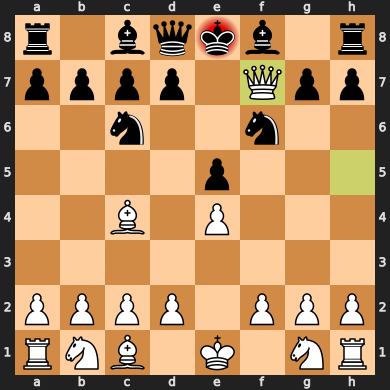

In [286]:
board = chess.Board()
board.push_san("e4")
board.push_san("e5")
board.push_san("Qh5")
board.push_san("Nc6")
board.push_san("Bc4")
board.push_san("Nf6")
board.push_san("Qxf7")
board.is_checkmate()
board

## Stockfish Intro

In [161]:
# set pos from starting pos
stockfish.set_position(["e2e4", "e7e6"])

# # set pos from current pos:
# stockfish.make_moves_from_current_position(["g4d7", "a8b8", "f1d1"])

# get best move 
stockfish.get_best_move()

# Get best move based on a time constraint
stockfish.get_best_move_time(1000)

# get current board position with FEN encoding
stockfish.get_fen_position()

# reset board position:
#-> dont need this since we just add to moves

'rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2'

## FEN to Board

In [5]:
def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( ['--'] * int(c) )
            elif c == 'p':
                brow.append( 'bp' )
            elif c == 'P':
                brow.append( 'wp' )
            elif c > 'Z':
                brow.append( 'b' + c.upper() )
            else:
                brow.append( 'w'+c )

        board.append( brow )
    return board

fen = "r1b2rk1/pp2ppbp/1nP2np1/q2PN3/8/2N3P1/PP2PPBP/R1BQK2R b KQ - 2 10"
pprint(fen_to_board(fen))

[['bR', '--', 'bB', '--', '--', 'bR', 'bK', '--'],

 ['bp', 'bp', '--', '--', 'bp', 'bp', 'bB', 'bp'],

 ['--', 'bN', 'wp', '--', '--', 'bN', 'bp', '--'],

 ['bQ', '--', '--', 'wp', 'wN', '--', '--', '--'],

 ['--', '--', '--', '--', '--', '--', '--', '--'],

 ['--', '--', 'wN', '--', '--', '--', 'wp', '--'],

 ['wp', 'wp', '--', '--', 'wp', 'wp', 'wB', 'wp'],

 ['wR', '--', 'wB', 'wQ', 'wK', '--', '--', 'wR']]


## Helper Methods

In [387]:
def checkEndCondition(board):
	if (board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.can_claim_threefold_repetition() or board.can_claim_fifty_moves() or board.can_claim_draw()):
		return True
	return False

def findNextIdx():
	files = (glob.glob(r"F:\Machine Learning & Data Science\Reinforcement Learning\HuggingFace - DRL Course\Unit Bonus - Chess\Chess-Personal\Chess-Engine-FreeCodeCamp\codes\data\rawData\*.npy"))
	if (len(files) == 0):
		return 1    # if no files, return 1
	highestIdx = 0
	for f in files:
		file = f
		currIdx = file.split("movesAndPositions")[-1].split(".npy")[0]
		highestIdx = max(highestIdx, int(currIdx))

	return int(highestIdx) + 1

def saveData(moves, positions):
	moves = np.array(moves).reshape(-1, 1)
	positions = np.array(positions).reshape(-1,1)
	movesAndPositions = np.concatenate((moves, positions), axis = 1)

	nextIdx = findNextIdx()
	np.save(f"data/rawData/movesAndPositions{nextIdx}.npy", movesAndPositions)
	print("Saved successfully")


# the runGame function makes it so you can run a game that you saved to check 
# the positions after numMoves number of moves.
def runGame(numMoves, filename = "movesAndPositions1.npy", fen = None):
	"""run a game you stored"""
	testing = np.load(f"data/rawData/{filename}")
	moves = testing[:, 0]
	if (numMoves > len(moves)):
		print("Must enter a lower number of moves than maximum game length. Game length here is: ", len(moves))
		return
	
	if fen == None:
		testBoard = chess.Board()
	else:
		testBoard = chess.Board(fen)

	for i in range(numMoves):
		move = moves[i]
		move = chess.Move.from_uci(str(move)) # convert to format chess package likes
		testBoard.push(move)
	return testBoard


## MineGames : Default FEN Board

First we will create data from default FEN Board. Later we will use a set of pre-loaded FEN Board to generate Data

- Here first set a max limit so a game does not last infinitely long.

- Then, run the number of games we want to run and make sure both Stockfish and the Chess pip package are reset to the starting position.

- Next, we get the top 3 moves suggested by Stockfish and choose one of them to play (80 % change for the best move, 15 % change for the second best move, 5 % change for the third best move). The reason we are not always choosing the best move is for the move selection to be more stochastic.

- Then, we choose a move (making sure no error occurs even if there are less than three possible moves), save the board position using FEN, as well as the move done from that position.

- If the game is done, we break the loop and store all positions and the moves made from those positions. If the game is not done, we continue making moves until the game is over.

In [ ]:
def mineGames(numGames : int):
	"""mines numGames games of moves"""
	MAX_MOVES = 1000    # don't continue games after this number

	for i in range(numGames):
		currentGameMoves = []
		currentGamePositions = []
		board = chess.Board()
		stockfish.set_position([])

		for i in range(MAX_MOVES):
			# randomly choose from those 3 moves
			moves = stockfish.get_top_moves(3)
			# if less than 3 moves available, choose first one, if none available, exit
			if (len(moves) == 0):
				print("game is over")
				break
			elif (len(moves) == 1):
				move = moves[0]["Move"]
			elif (len(moves) == 2):
				move = random.choices(moves, weights=(80, 20), k=1)[0]["Move"]
			else:
				move = random.choices(moves, weights=(80, 15, 5), k=1)[0]["Move"]

			currentGamePositions.append(stockfish.get_fen_position())
			currentGameMoves.append(move)         # make sure to add str version of move before changing format
			move = chess.Move.from_uci(str(move)) # convert to format chess package likes
			board.push(move)
			stockfish.set_position(currentGameMoves)
			if (checkEndCondition(board)):
				print("game is over")
				break
		    
		saveData(currentGameMoves, currentGamePositions)

mineGames(150)

## MineGames : Pre-Loaded FEN Board

Here the FEN boards are not same. They will be all unique. So, this data generation process more promising and efficient. Generation process same just using pre-loaded datasets from kaggle

### First Dataset : Kaggle

https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data

(1000,)

rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1

rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2

rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2

rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3

rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQKBNR b KQkq - 1 3

rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQKBNR w KQkq - 2 4

rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQKBNR b KQkq - 0 4

rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQKBNR w KQkq - 1 5

rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1BQKBNR b KQkq - 0 5

rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1BQKBNR w KQkq - 0 6


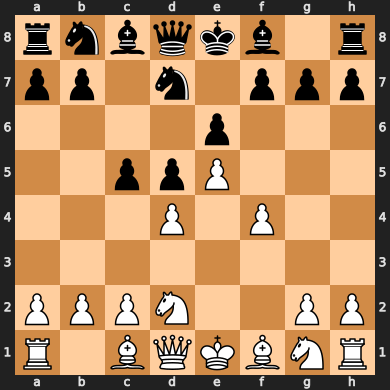

In [ ]:
import pandas as pd

loaded_data = pd.read_csv('data\loaded-datasets\chessData.csv', nrows=1000)
loaded_data = loaded_data.drop(columns=['Evaluation'], axis=1)
loaded_fens = loaded_data.to_numpy().flatten()
print(loaded_fens.shape)

for i in range(10):
    print(loaded_fens[i])
    board = chess.Board(loaded_fens[i])

board

As the dataset is large, We can make more smart data by only taking '+#' evaluated fens. + means advantage for white, # means mate condition. Here is the idea.

To optimize our dataset for training a model for White, follow this prioritization:

1. **Checkmate Sequences (`#+`)**: Start with these rows as they contain forced checkmate sequences, offering valuable training data on decisive winning moves.
2. **High Positive Evaluation Scores**: Next, select rows with high positive evaluation scores, as they represent strong positions favoring White.

This approach ensures that your model learns both how to execute checkmates and how to maintain strong positional advantages.

In [ ]:
df = pd.read_csv('data\loaded-datasets\chessData.csv')

# Filter rows with checkmate sequences for White ('#+')
checkmate_rows = df[df['Evaluation'].str.contains('#\+')]

# Filter rows with high positive evaluation scores
# Assuming a threshold of 1000 for high positive scores
high_positive_rows = df[pd.to_numeric(df['Evaluation'], errors='coerce') > 1000]

# Combine both filters
filtered_rows = pd.concat([checkmate_rows, high_positive_rows])

# Remove duplicates if any
filtered_rows = filtered_rows.drop_duplicates()

# Sort the dataset, placing checkmate rows first
sorted_rows = pd.concat([checkmate_rows, high_positive_rows]).reset_index(drop=True)

# Select only 10K rows
final_rows = sorted_rows.head(10000)

final_rows.head()[:5]

(10000,)

7k/p1r2b2/4pq2/1p1p1nR1/5P2/P2B4/1P2Q2P/1K4R1 w - - 3 31

7k/p1r2b2/4pq2/1p1p1BR1/5P2/P7/1P2Q2P/1K4R1 b - - 0 31

7k/p1r2b2/5q2/1p1p1pR1/5P2/P7/1P2Q2P/1K4R1 w - - 0 32

7k/p1r2b2/5q2/1p1p1p1R/5P2/P7/1P2Q2P/1K4R1 b - - 1 32

3r3k/p4Q2/3bp2p/2ppqp2/8/P1P3RP/1P3PP1/3R2K1 w - - 0 33

3r3k/p4Q2/3bp1Rp/2ppqp2/8/P1P4P/1P3PP1/3R2K1 b - - 1 33

3q3r/5R2/7k/1b1pPp1p/p2P4/Q7/6PP/1r2BRK1 w - - 0 32

8/1Pk5/2PbK2p/6p1/3B2P1/5p1P/8/8 w - - 1 57

1k6/8/2PbK2p/6p1/3B2P1/5p1P/8/8 w - - 0 58

1k6/8/2PK3p/6p1/3B2P1/5p1P/8/8 b - - 0 58


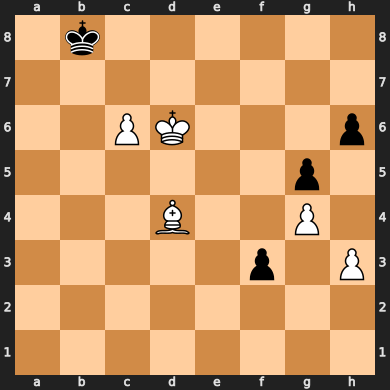

In [ ]:
loaded_data = final_rows.drop(columns=['Evaluation'], axis=1)
loaded_fens = loaded_data.to_numpy().flatten()
print(loaded_fens.shape)

for i in range(10):
    print(loaded_fens[i])
    board = chess.Board(loaded_fens[i])

board

In [ ]:
def mineGames_loaded(numGames : int):
	"""mines numGames games of moves"""
	MAX_MOVES = 1000    # don't continue games after this number
	fen_idx = 0

	stockfish = Stockfish(path=r"F:\Machine Learning & Data Science\Reinforcement Learning\HuggingFace - DRL Course\Unit Bonus - Chess\Chess-Personal\Chess-Engine-FreeCodeCamp\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")

	for _ in range(numGames):
		currentGameMoves = []
		currentGamePositions = []
		board = chess.Board(loaded_fens[fen_idx])
		stockfish.set_fen_position(loaded_fens[fen_idx])
		fen_idx += 1

		for _ in range(MAX_MOVES):
			# randomly choose from those 3 moves
			moves = stockfish.get_top_moves(3)
			# if less than 3 moves available, choose first one, if none available, exit
			if (len(moves) == 0):
				print("game is over")
				break
			elif (len(moves) == 1):
				move = moves[0]["Move"]
			elif (len(moves) == 2):
				move = random.choices(moves, weights=(80, 20), k=1)[0]["Move"]
			else:
				move = random.choices(moves, weights=(80, 15, 5), k=1)[0]["Move"]


			currentGamePositions.append(stockfish.get_fen_position())
			currentGameMoves.append(move)         # make sure to add str version of move before changing format
			move = chess.Move.from_uci(str(move)) # convert to format chess package likes
			board.push(move)
			# stockfish.set_position(currentGameMoves)
			stockfish.set_fen_position(board.fen())
			if (checkEndCondition(board)):
				print("game is over")
				break
		    
		saveData(currentGameMoves, currentGamePositions)

mineGames_loaded(100)

### (Best) Second Dataset : Lichess DB 

https://database.lichess.org/#puzzles

It has the biggest advantage as we dont need any script to generate moves as it is already given. So a lot of preprocessing time is saved

In [452]:
df = pd.read_csv('data\loaded-datasets\lichess_db_puzzle.csv')

# Filter rows with high positive evaluation scores
# Assuming a threshold of 1000 for high positive scores
high_positive_rows = df[pd.to_numeric(df['Rating'], errors='coerce') > 1800]

# Remove duplicates if any
filtered_rows = high_positive_rows.drop_duplicates()

# Sort the dataset
sorted_rows = filtered_rows.sort_values(by='Rating', ascending=False).reset_index(drop=True)

# Remove all columns except for the 'FEN' and  'Moves' column
final_rows = sorted_rows[['FEN', 'Moves']]

# Select only 50K rows
final_rows = final_rows.head(50000)

final_rows.head()

,FEN,Moves
0,4n1k1/5ppp/3p4/2pP1P1N/1pPb3q/1P3QB1/2r4P/5R1K...,h4e7 f1e1 d4e5 g3e5 d6e5 f5f6 e7d6 e1a1
1,r1bqr2k/pp3pp1/3p1n1p/2pPn3/2P1P2Q/1P1B2RP/P5P...,e5d3 c1h6 c8g4 a1f1 d3e5 h6g5 h8g8 f1f6 d8a5 g...
2,6k1/3n1q1p/p1r1p1p1/1p4B1/4N2P/1P6/P4PP1/3Q2K1...,d7e5 e4f6 g8g7 d1d8 c6c1 g5c1
3,8/4n3/4p1pp/2k5/2p1BP2/2P1K1P1/7P/8 b - - 3 48,e7d5 e4d5 c5d5 e3f3 e6e5 f3e3 d5e6 e3e4 e5f4 e4f4
4,3rq3/p1p2pk1/bn4pp/4P3/3Q4/5N2/PPP2PPP/R3K2R w...,d4c3 e8b5 e5e6 g7h7 c3e3 b5b2 e3e5 b2c2 e6f7 b6d7


(50000,)

(50000,)

4n1k1/5ppp/3p4/2pP1P1N/1pPb3q/1P3QB1/2r4P/5R1K b - - 6 36 h4e7 f1e1 d4e5 g3e5 d6e5 f5f6 e7d6 e1a1

r1bqr2k/pp3pp1/3p1n1p/2pPn3/2P1P2Q/1P1B2RP/P5P1/R1B3K1 b - - 4 20 e5d3 c1h6 c8g4 a1f1 d3e5 h6g5 h8g8 f1f6 d8a5 g1h2 a5e1 f6f4 e5g6 h4g4

6k1/3n1q1p/p1r1p1p1/1p4B1/4N2P/1P6/P4PP1/3Q2K1 b - - 0 35 d7e5 e4f6 g8g7 d1d8 c6c1 g5c1

8/4n3/4p1pp/2k5/2p1BP2/2P1K1P1/7P/8 b - - 3 48 e7d5 e4d5 c5d5 e3f3 e6e5 f3e3 d5e6 e3e4 e5f4 e4f4

3rq3/p1p2pk1/bn4pp/4P3/3Q4/5N2/PPP2PPP/R3K2R w KQ - 3 17 d4c3 e8b5 e5e6 g7h7 c3e3 b5b2 e3e5 b2c2 e6f7 b6d7

7k/4QP2/2p2n2/p3P3/P1pP4/1pP2K2/1q3P2/8 b - - 1 33 b2c3 f3g2 f6h7 e7d7 c3b4 e5e6 h7f8 d7d8 b3b2 e6e7 b4e7 d8e7

1r4k1/r4pp1/4p2p/2P1P3/3PQ3/p1q1P2P/R5PK/R7 w - - 2 31 e4c6 c3e3 c6d6 a7b7 a1f1 b7b1

4q1k1/1pp2rp1/1n4RP/3pPpQ1/1p3B2/2P1P3/4KP2/r7 b - - 2 30 a1a2 e2f1 e8e7 g5g3 g8h7 e5e6 b6d7 f4g5

1r1kBb1r/p3pp1p/2p5/3p2p1/Q2P4/2P1P1P1/Pq3PP1/RN2K1NR w KQ - 0 14 a4c6 b2c1 e1e2 b8b2 b1d2 c1d2 e2f3 d2f2 f3g4 h7h5 h1h5 f7f5 g4g5 h8g8 e8g6 f2e3 g5f5 e

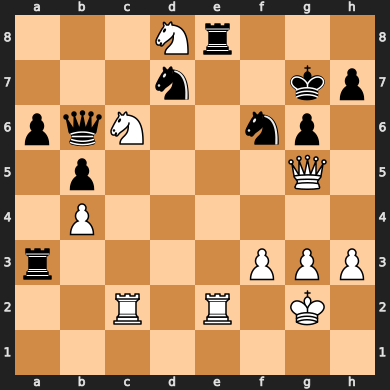

In [453]:
loaded_fens = final_rows['FEN'].to_numpy().flatten()
loaded_moves = final_rows['Moves'].to_numpy().flatten()

print(loaded_fens.shape)
print(loaded_moves.shape)

for i in range(10):
    print(loaded_fens[i], loaded_moves[i])
    board = chess.Board(loaded_fens[i])

board

In [ ]:
def mineGames_final(numGames: int):
    """Mines numGames games of moves"""
    fen_idx = 0

    stockfish = Stockfish(path=r"F:\Machine Learning & Data Science\Reinforcement Learning\HuggingFace - DRL Course\Unit Bonus - Chess\Chess-Personal\Chess-Engine-FreeCodeCamp\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")

    for _ in range(numGames):
        currentGameMoves = []
        currentGamePositions = []
        board = chess.Board(loaded_fens[fen_idx])
        stockfish.set_fen_position(loaded_fens[fen_idx])
        moves = loaded_moves[fen_idx].split()
        fen_idx += 1

        # Apply the first move to get to the player's position
        first_move = chess.Move.from_uci(moves[0])
        board.push(first_move)
        stockfish.set_fen_position(board.fen())
        currentGamePositions.append(stockfish.get_fen_position())
        currentGameMoves.append(moves[0])
        
        for move in moves[1:]:
            currentGamePositions.append(stockfish.get_fen_position())
            currentGameMoves.append(move)
            move = chess.Move.from_uci(str(move))
            board.push(move)
            stockfish.set_fen_position(board.fen())
            if checkEndCondition(board):
                print("game is over")
                break

        saveData(currentGameMoves, currentGamePositions)

mineGames_final(50000)

## Play Game

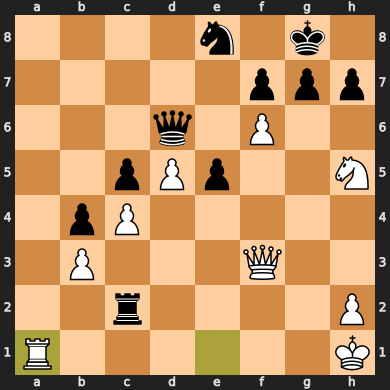

In [459]:
testBoard = runGame(8, "movesAndPositions1.npy", loaded_fens[0])
testBoard

# Part II : Encode Chess Data

In [460]:
import numpy as np
import gym
import chess
import os
import gym.spaces
from gym_chess.alphazero.move_encoding import utils, queenmoves, knightmoves, underpromotions
from typing import List

In [461]:
env = gym.make('ChessAlphaZero-v0')
env.reset()
print(env.observation_space)
print(env.action_space)

Box(0, 2147483647, (8, 8, 119), int32)

Discrete(4672)


In [12]:
# encode:
move = chess.Move.from_uci('e2e4')
env.encode(move)

877

In [13]:
# decode
env.decode(1000)

Move.from_uci('f2c5')

## Fix Gym-Chess Encoding

In [14]:
def encodeKnight(move: chess.Move):
    _NUM_TYPES: int = 8

    #: Starting point of knight moves in last dimension of 8 x 8 x 73 action array.
    _TYPE_OFFSET: int = 56

    #: Set of possible directions for a knight move, encoded as 
    #: (delta rank, delta square).
    _DIRECTIONS = utils.IndexedTuple(
        (+2, +1),
        (+1, +2),
        (-1, +2),
        (-2, +1),
        (-2, -1),
        (-1, -2),
        (+1, -2),
        (+2, -1),
    )

    from_rank, from_file, to_rank, to_file = utils.unpack(move)

    delta = (to_rank - from_rank, to_file - from_file)
    is_knight_move = delta in _DIRECTIONS
    
    if not is_knight_move:
        return None

    knight_move_type = _DIRECTIONS.index(delta)
    move_type = _TYPE_OFFSET + knight_move_type

    action = np.ravel_multi_index(
        multi_index=((from_rank, from_file, move_type)),
        dims=(8, 8, 73)
    )

    return action


def encodeQueen(move: chess.Move):
    _NUM_TYPES: int = 56        # = 8 directions * 7 squares max. distance
    _DIRECTIONS = utils.IndexedTuple(
        (+1,  0),
        (+1, +1),
        ( 0, +1),
        (-1, +1),
        (-1,  0),
        (-1, -1),
        ( 0, -1),
        (+1, -1),
    )

    from_rank, from_file, to_rank, to_file = utils.unpack(move)

    delta = (to_rank - from_rank, to_file - from_file)

    is_horizontal = delta[0] == 0
    is_vertical = delta[1] == 0
    is_diagonal = abs(delta[0]) == abs(delta[1])
    is_queen_move_promotion = move.promotion in (chess.QUEEN, None)

    is_queen_move = (
        (is_horizontal or is_vertical or is_diagonal) 
            and is_queen_move_promotion
    )

    if not is_queen_move:
        return None

    direction = tuple(np.sign(delta))
    distance = np.max(np.abs(delta))

    direction_idx = _DIRECTIONS.index(direction)
    distance_idx = distance - 1

    move_type = np.ravel_multi_index(
        multi_index=([direction_idx, distance_idx]),
        dims=(8,7)
    )

    action = np.ravel_multi_index(
        multi_index=((from_rank, from_file, move_type)),
        dims=(8, 8, 73)
    )

    return action

In [15]:
def encodeUnder(move):
    _NUM_TYPES: int = 9 # = 3 directions * 3 piece types (see below)
    _TYPE_OFFSET: int = 64
    _DIRECTIONS = utils.IndexedTuple(
        -1,
        0,
        +1,
    )
    _PROMOTIONS = utils.IndexedTuple(
        chess.KNIGHT,
        chess.BISHOP,
        chess.ROOK,
    )

    from_rank, from_file, to_rank, to_file = utils.unpack(move)

    is_underpromotion = (
        move.promotion in _PROMOTIONS 
        and from_rank == 6 
        and to_rank == 7
    )

    if not is_underpromotion:
        return None

    delta_file = to_file - from_file

    direction_idx = _DIRECTIONS.index(delta_file)
    promotion_idx = _PROMOTIONS.index(move.promotion)

    underpromotion_type = np.ravel_multi_index(
        multi_index=([direction_idx, promotion_idx]),
        dims=(3,3)
    )

    move_type = _TYPE_OFFSET + underpromotion_type

    action = np.ravel_multi_index(
        multi_index=((from_rank, from_file, move_type)),
        dims=(8, 8, 73)
    )

    return action


In [16]:
def encodeMove(move: str, board) -> int:
    move = chess.Move.from_uci(move)
    if board.turn == chess.BLACK:
        move = utils.rotate(move)

    action = encodeQueen(move)

    if action is None:
        action = encodeKnight(move)

    if action is None:
        action = encodeUnder(move)

    if action is None:
        raise ValueError(f"{move} is not a valid move")

    return action

## Encode AlphaZero

In [17]:
def encodeBoard(board: chess.Board) -> np.array:
	"""Converts a board to numpy array representation."""

	array = np.zeros((8, 8, 14), dtype=int)

	for square, piece in board.piece_map().items():
		rank, file = chess.square_rank(square), chess.square_file(square)
		piece_type, color = piece.piece_type, piece.color
	
		# The first six planes encode the pieces of the active player, 
		# the following six those of the active player's opponent. Since
		# this class always stores boards oriented towards the white player,
		# White is considered to be the active player here.
		offset = 0 if color == chess.WHITE else 6
		
		# Chess enumerates piece types beginning with one, which we have to account for
		idx = piece_type - 1
	
		array[rank, file, idx + offset] = 1

	# Repetition counters
	array[:, :, 12] = board.is_repetition(2)
	array[:, :, 13] = board.is_repetition(3)

	return array


def encodeBoardFromFen(fen: str) -> np.array:
	board = chess.Board(fen)
	return encodeBoard(board)


def decodeMove(move: int):
	return env.decode(move)

## Encode All Moves & Positions

- data/rawData : generated from part I. moves in string format and positions in FEN-format
- data/preparedData : encoded moves and positions

- shape of files:
    - moves: (number of moves in game)
    - positions: (number of moves in game, 8, 8, 14) (number of moves in game is including both black and white moves)

In [ ]:
def encodeAllMovesAndPositions():
    board = chess.Board() # this is used to change whose turn it is so that the encoding works
    board.turn = False    # set turn to black first, changed on first run

    #find all files in folder:
    files = os.listdir('data/rawData')
    for idx, f in enumerate(files):
        movesAndPositions = np.load(f'data/rawData/{f}', allow_pickle=True)
        moves = movesAndPositions[:,0]
        positions = movesAndPositions[:,1]
        encodedMoves = []
        encodedPositions = []


        for i in range(len(moves)):
            board.turn = (not board.turn) # swap turns
            try:
                encodedMoves.append(encodeMove(moves[i], board)) 
                encodedPositions.append(encodeBoardFromFen(positions[i]))
            except:
                try:
                    board.turn = (not board.turn) # change turn, since we skip moves sometimes, we might need to change turn
                    encodedMoves.append(encodeMove(moves[i], board)) 
                    encodedPositions.append(encodeBoardFromFen(positions[i]))
                except:
                    print(f'error in file: {f}')
                    print("Turn: ", board.turn)
                    print(moves[i])
                    print(positions[i])
                    print(i)
                    break
            
        np.save(f'data/preparedData/moves{idx}', np.array(encodedMoves))
        np.save(f'data/preparedData/positions{idx}', np.array(encodedPositions))
    
encodeAllMovesAndPositions()

# Part III : Build AI Chess Engine

In [622]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import gym
import gym_chess
import os
import copy
import chess
from tqdm import tqdm
from gym_chess.alphazero.move_encoding import utils
from pathlib import Path
from typing import Optional

In [623]:
torch.cuda.is_available()

False

## Fix Gym-Chess Decoding

decoding moves from idx to uci notation

In [22]:
def _decodeKnight(action: int) -> Optional[chess.Move]:
    _NUM_TYPES: int = 8

    #: Starting point of knight moves in last dimension of 8 x 8 x 73 action array.
    _TYPE_OFFSET: int = 56

    #: Set of possible directions for a knight move, encoded as 
    #: (delta rank, delta square).
    _DIRECTIONS = utils.IndexedTuple(
        (+2, +1),
        (+1, +2),
        (-1, +2),
        (-2, +1),
        (-2, -1),
        (-1, -2),
        (+1, -2),
        (+2, -1),
    )

    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))

    is_knight_move = (
        _TYPE_OFFSET <= move_type
        and move_type < _TYPE_OFFSET + _NUM_TYPES
    )

    if not is_knight_move:
        return None

    knight_move_type = move_type - _TYPE_OFFSET

    delta_rank, delta_file = _DIRECTIONS[knight_move_type]

    to_rank = from_rank + delta_rank
    to_file = from_file + delta_file

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    return move


def _decodeQueen(action: int) -> Optional[chess.Move]:

    _NUM_TYPES: int = 56 # = 8 directions * 7 squares max. distance

    #: Set of possible directions for a queen move, encoded as 
    #: (delta rank, delta square).
    _DIRECTIONS = utils.IndexedTuple(
        (+1,  0),
        (+1, +1),
        ( 0, +1),
        (-1, +1),
        (-1,  0),
        (-1, -1),
        ( 0, -1),
        (+1, -1),
    )
    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))
    
    is_queen_move = move_type < _NUM_TYPES

    if not is_queen_move:
        return None

    direction_idx, distance_idx = np.unravel_index(
        indices=move_type,
        shape=(8,7)
    )

    direction = _DIRECTIONS[direction_idx]
    distance = distance_idx + 1

    delta_rank = direction[0] * distance
    delta_file = direction[1] * distance

    to_rank = from_rank + delta_rank
    to_file = from_file + delta_file

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    return move

In [23]:
def _decodeUnderPromotion(action):
    _NUM_TYPES: int = 9 # = 3 directions * 3 piece types (see below)

    #: Starting point of underpromotions in last dimension of 8 x 8 x 73 action 
    #: array.
    _TYPE_OFFSET: int = 64

    #: Set of possibel directions for an underpromotion, encoded as file delta.
    _DIRECTIONS = utils.IndexedTuple(
        -1,
        0,
        +1,
    )

    #: Set of possibel piece types for an underpromotion (promoting to a queen
    #: is implicitly encoded by the corresponding queen move).
    _PROMOTIONS = utils.IndexedTuple(
        chess.KNIGHT,
        chess.BISHOP,
        chess.ROOK,
    )

    from_rank, from_file, move_type = np.unravel_index(action, (8, 8, 73))

    is_underpromotion = (
        _TYPE_OFFSET <= move_type
        and move_type < _TYPE_OFFSET + _NUM_TYPES
    )

    if not is_underpromotion:
        return None

    underpromotion_type = move_type - _TYPE_OFFSET

    direction_idx, promotion_idx = np.unravel_index(
        indices=underpromotion_type,
        shape=(3,3)
    )

    direction = _DIRECTIONS[direction_idx]
    promotion = _PROMOTIONS[promotion_idx]

    to_rank = from_rank + 1
    to_file = from_file + direction

    move = utils.pack(from_rank, from_file, to_rank, to_file)
    move.promotion = promotion

    return move

In [24]:
def decodeMove(action: int, board) -> chess.Move:
    move = _decodeQueen(action)
    is_queen_move = move is not None

    if not move:
        move = _decodeKnight(action)

    if not move:
        move = _decodeUnderPromotion(action)

    if not move:
        raise ValueError(f"{action} is not a valid action")

    # Actions encode moves from the perspective of the current player. If
    # this is the black player, the move must be reoriented.
    turn = board.turn
    
    if turn == False: #black to move
        move = utils.rotate(move)

    # Moving a pawn to the opponent's home rank with a queen move
    # is automatically assumed to be queen underpromotion. However,
    # since queenmoves has no reference to the board and can thus not
    # determine whether the moved piece is a pawn, we have to add this
    # information manually here
    if is_queen_move:
        to_rank = chess.square_rank(move.to_square)
        is_promoting_move = (
            (to_rank == 7 and turn == True) or 
            (to_rank == 0 and turn == False)
        )

        piece = board.piece_at(move.from_square)
        if piece is None: #NOTE I added this, not entirely sure if it's correct
            return None
        is_pawn = piece.piece_type == chess.PAWN

        if is_pawn and is_promoting_move:
            move.promotion = chess.QUEEN

    return move

## Load Data

In [581]:
USE_SIMPLE_MODEL = False
FRACTION_OF_DATA = 0.7
BATCH_SIZE = 128

In [579]:
allMoves = []
allBoards = []

files = os.listdir('data/preparedData')
numOfEach = len(files) // 2 # half are moves, other half are positions

for i in range(numOfEach):
    try:
        moves = np.load(f"data/preparedData/moves{i}.npy", allow_pickle=True)
        boards = np.load(f"data/preparedData/positions{i}.npy", allow_pickle=True)
        if (len(moves) != len(boards)):
            print("ERROR ON i = ", i, len(moves), len(boards))
        allMoves.extend(moves)
        allBoards.extend(boards)
    except:
        pass
        

allMoves = np.array(allMoves)[:(int(len(allMoves) * FRACTION_OF_DATA))]
allBoards = np.array(allBoards)[:(int(len(allBoards) * FRACTION_OF_DATA))]
assert len(allMoves) == len(allBoards), "MUST BE OF SAME LENGTH"

## flatten out boards
# allBoards = allBoards.reshape(allBoards.shape[0], -1)

trainDataIdx = int(len(allMoves) * 0.8)

# transfer all data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
allBoards = torch.from_numpy(np.asarray(allBoards)).to(device)
allMoves = torch.from_numpy(np.asarray(allMoves)).to(device)

In [583]:
# for complex model, even 1 epoch takes too long. so, taking 40% of data
# Adjust the data size based on model complexity
if not USE_SIMPLE_MODEL:
    fraction = 0.4  # Use 40% of the data for complex models

    finalBoards = np.array(allBoards[:int(len(allBoards) * fraction)])
    finalMoves = np.array(allMoves[:int(len(allMoves) * fraction)])
    finaltrainDataIdx = int(len(finalMoves) * 0.8)

    # Convert to tensors
    finalBoards = torch.from_numpy(np.asarray(finalBoards)).to(device)
    finalMoves = torch.from_numpy(np.asarray(finalMoves)).to(device)

    training_set = torch.utils.data.TensorDataset(finalBoards[:finaltrainDataIdx], finalMoves[:finaltrainDataIdx])
    test_set = torch.utils.data.TensorDataset(finalBoards[finaltrainDataIdx:], finalMoves[finaltrainDataIdx:])

    length = len(finalMoves)
else:
    training_set = torch.utils.data.TensorDataset(allBoards[:trainDataIdx], allMoves[:trainDataIdx])
    test_set = torch.utils.data.TensorDataset(allBoards[trainDataIdx:], allMoves[trainDataIdx:])
    length = len(allMoves)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"loaded {length} moves and positions")

loaded 129265 moves and positions


## Build Model

Notes:

board shape: (batch shape, 896)

can check turn with "board.turn" -> **true** means **white** to move, **false** means **black** to move

4672 potential moves (so can encode from 0 -> 4671 inclusive)

In [584]:
if USE_SIMPLE_MODEL:
    class Model(torch.nn.Module):

        def __init__(self):
            super(Model, self).__init__()
            # self.INPUT_SIZE = 896   # if not using cnn
            self.INPUT_SIZE = 7*7*13  # NOTE changing input size for using cnns

            self.OUTPUT_SIZE = 4672 # = number of unique moves (action space)
            
            # try to add CNN and pooling here (calculations taking into account spacial features)

            # input shape for sample is (8,8,14), flattened to 1d array of size 896
            # self.cnn1 = nn.Conv3d(64, 1,(8,8,14), padding=(0,0,1))

            self.conv1 = nn.Conv2d(14, 32, kernel_size=3, stride=1, padding=1)  # input channels = 14 (8x8x14)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

            # self.activation = torch.nn.Tanh()   
            self.activation = torch.nn.ReLU()

            # self.linear1 = torch.nn.Linear(self.INPUT_SIZE, 1000)    # if not using cnn

            self.fc_input_size = 64 * 2 * 2  # Adjust this based on the output size after the CNN layers
            self.linear1 = nn.Linear(self.fc_input_size, 1000)

            self.linear2 = torch.nn.Linear(1000, 1000)
            self.linear3 = torch.nn.Linear(1000, 1000)
            self.linear4 = torch.nn.Linear(1000, 200)
            self.linear5 = torch.nn.Linear(200, self.OUTPUT_SIZE)
            self.softmax = torch.nn.Softmax(1) # use softmax as prob for each move, dim 1 as dim 0 is the batch dimension
    
        def forward(self, x): #x.shape = (batch size, 896)
            x = x.to(torch.float32)
            
            x = x.view(-1, 14, 8, 8)  # Reshape input to (batch_size, channels, height, width)

            # CNN layers
            x = self.pool(self.activation(self.conv1(x)))
            x = self.pool(self.activation(self.conv2(x)))

            # Flatten the tensor
            x = x.reshape(x.size(0), -1)

            # x = self.cnn1(x) # for using cnns

            # Fully connected layers
            x = self.activation(self.linear1(x))
            x = self.activation(self.linear2(x))
            x = self.activation(self.linear3(x))
            x = self.activation(self.linear4(x))
            x = self.linear5(x)
            # x = self.softmax(x) # do not use softmax since you are using cross entropy loss
            return x

        def predict(self, board : chess.Board):
            """takes in a chess board and returns a chess.move object. 
            NOTE: this function should definitely be written better, but it works for now"""

            with torch.no_grad():
                encodedBoard = encodeBoard(board)
                encodedBoard = encodedBoard.reshape(1, -1)
                encodedBoard = torch.from_numpy(encodedBoard)
                res = self.forward(encodedBoard)
                probs = self.softmax(res)

                probs = probs.numpy()[0] # do not want tensor anymore, 0 since it is a 2d array with 1 row

                # verify that move is legal and can be decoded before returning
                while len(probs) > 0: #try max 100 times, if not throw an error
                    moveIdx = probs.argmax()
                    try: #TODO should not have try here, but was a bug with idx 499 if it is black to move
                        uciMove = decodeMove(moveIdx, board)
                        if (uciMove is None): # could not decode
                            probs = np.delete(probs, moveIdx)
                            continue
                        move = chess.Move.from_uci(str(uciMove))
                        if (move in board.legal_moves): # if legal, return, else: loop continues after deleting the move
                            return move 
                    except:
                        pass
                    probs = np.delete(probs, moveIdx) # TODO probably better way to do this, but it is not too time critical as it is only for predictions
                                                    # remove the move so its not chosen again next iteration
                
                # return random move if model failed to find move
                moves = board.legal_moves
                if (len(moves) > 0):
                    return np.random.choice(list(moves))
                return None # if no legal moves found, return None

## Advanced & Complex Model

We can use advanced complex model for smart model. This architecture is taken from here: [CrazyAra-v0.2](https://github.com/QueensGambit/CrazyAra/wiki/Model-architecture). It is a combination of ResneXt, Inception, Squeeze and Excitation architecture

In [585]:
if not USE_SIMPLE_MODEL:
    
    class SqueezeExcitation(nn.Module):
        def __init__(self, channels, reduction=16):
            super(SqueezeExcitation, self).__init__()
            self.fc1 = nn.Linear(channels, channels // reduction)
            self.fc2 = nn.Linear(channels // reduction, channels)

        def forward(self, x):
            batch, channels, _, _ = x.size()
            y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
            y = F.relu(self.fc1(y))
            y = torch.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
            return x * y


    class BottleneckResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1, reduction=16):
            super(BottleneckResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.se = SqueezeExcitation(out_channels, reduction)

            self.downsample = None
            if stride != 1 or in_channels != out_channels:
                self.downsample = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_channels)
                )

        def forward(self, x):
            identity = x
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.se(out)
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
            out = self.relu(out)
            return out

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.INPUT_SIZE = 7 * 7 * 13
            self.OUTPUT_SIZE = 4672

            # Stem
            self.stem = nn.Sequential(
                nn.Conv2d(14, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

            # Residual Blocks
            self.residual_blocks = nn.Sequential(
                BottleneckResidualBlock(64, 128, stride=2),
                BottleneckResidualBlock(128, 256, stride=2),
                BottleneckResidualBlock(256, 512, stride=2)
            )

            # # Value Head
            # self.value_head = nn.Sequential(
            #     nn.Conv2d(512, 128, kernel_size=1),
            #     nn.BatchNorm2d(128),
            #     nn.ReLU(inplace=True),
            #     nn.Flatten(),
            #     nn.Linear(128 * 1 * 1, 256),
            #     nn.ReLU(inplace=True),
            #     nn.Linear(256, 1),
            #     nn.Tanh()
            # )

            # Policy Head
            self.policy_head = nn.Sequential(
                nn.Conv2d(512, 256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Flatten(),
                nn.Linear(256 * 1 * 1, self.OUTPUT_SIZE)
            )

        def forward(self, x):
            x = x.to(torch.float32)
            x = x.view(-1, 14, 8, 8)
            x = self.stem(x)
            x = self.residual_blocks(x)
            # value = self.value_head(x)
            policy = self.policy_head(x)
            # return policy, value
            return policy

        def predict(self, board: chess.Board):
            with torch.no_grad():
                encodedBoard = encodeBoard(board)
                encodedBoard = encodedBoard.reshape(1, -1)
                encodedBoard = torch.from_numpy(encodedBoard)
                policy = self.forward(encodedBoard)
                probs = F.softmax(policy, dim=1)

                probs = probs.numpy()[0]

                while len(probs) > 0:
                    moveIdx = probs.argmax()
                    try:
                        uciMove = decodeMove(moveIdx, board)
                        if uciMove is None:
                            probs = np.delete(probs, moveIdx)
                            continue
                        move = chess.Move.from_uci(str(uciMove))
                        if move in board.legal_moves:
                            return move
                    except:
                        pass
                    probs = np.delete(probs, moveIdx)

                moves = list(board.legal_moves)
                if len(moves) > 0:
                    return np.random.choice(moves)
                return None

## Train Model

In [586]:
def createBestModelFile():
    #first find best model if it exists:
    path = Path('./savedModels/bestModel.txt')

    if not (path.is_file()):
        #create the files
        f = open(path, "w")
        f.write("10000000") #set to high number so it is overwritten with better loss
        f.write("\ntestPath")
        f.close()

def saveBestModel(vloss, pathToBestModel):
    f = open("./savedModels/bestModel.txt", "w")
    f.write(str(vloss.item()))
    f.write("\n")
    f.write(pathToBestModel)
    print("NEW BEST MODEL FOUND WITH LOSS:", vloss)

def retrieveBestModelInfo():
    f = open('./savedModels/bestModel.txt', "r")
    bestLoss = float(f.readline())
    bestModelPath = f.readline()
    f.close()
    return bestLoss, bestModelPath

In [588]:
def train_one_epoch(model, optimizer, loss_fn, epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):

        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % BATCH_SIZE == BATCH_SIZE - 1:
            last_loss = running_loss / BATCH_SIZE # loss per batch
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [589]:
EPOCHS = 5
LEARNING_RATE = 0.007
MOMENTUM = 0.95
WEIGHT_DECAY = 1e-4

In [590]:
createBestModelFile()

bestLoss, bestModelPath = retrieveBestModelInfo()

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

model = Model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

best_vloss = 1_000_000.

best_weights = None
patience = 25

for epoch in tqdm(range(EPOCHS)):
    if (epoch_number % 1 == 0):
        print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    
    avg_loss = train_one_epoch(model, optimizer, loss_fn, epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, v_labels = vdata     # change for complex model accordingly
            voutputs = model(vinputs)

            vloss = loss_fn(voutputs, v_labels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    # only print every 10 epochs
    if epoch_number % 1 == 0:
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        if (bestLoss > best_vloss): # if better than previous best loss from all models created, save it
            model_path = 'savedModels/model_{}_{}'.format(timestamp, epoch_number)
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, model_path)
            saveBestModel(best_vloss, model_path)
            bestLoss = best_vloss
            
        else: # Early stopping
            patience -= 1
            if patience == 0:
                print("EARLY STOPPING")
                break

    epoch_number += 1

print("\n\nBEST VALIDATION LOSS FOR ALL MODELS: ", bestLoss)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1:


 20%|██        | 1/5 [06:00<24:00, 360.17s/it]

LOSS train 6.984010647982359 valid 6.942723274230957

EPOCH 2:


 40%|████      | 2/5 [12:00<18:01, 360.47s/it]

LOSS train 6.638657230883837 valid 6.69647216796875

NEW BEST MODEL FOUND WITH LOSS: tensor(6.6965)

EPOCH 3:


 60%|██████    | 3/5 [18:03<12:03, 361.60s/it]

LOSS train 6.3347437381744385 valid 6.5573954582214355

NEW BEST MODEL FOUND WITH LOSS: tensor(6.5574)

EPOCH 4:


 80%|████████  | 4/5 [24:05<06:01, 361.81s/it]

LOSS train 6.048083271831274 valid 6.488326549530029

NEW BEST MODEL FOUND WITH LOSS: tensor(6.4883)

EPOCH 5:


100%|██████████| 5/5 [30:21<00:00, 364.34s/it]

LOSS train 5.781437333673239 valid 6.457859992980957

NEW BEST MODEL FOUND WITH LOSS: tensor(6.4579)





BEST VALIDATION LOSS FOR ALL MODELS:  tensor(6.4579)


## Evaluate Trained Model

## Trained Agent vs Myself

### Load Saved Model

In [624]:
saved_model = Model()

#load best model path from your file
f = open("./savedModels/bestModel.txt", "r")
bestLoss = float(f.readline())
model_path = f.readline()
f.close()
print("BEST MODEL: ", bestLoss, model_path)

# saved_model.load_state_dict(torch.load(model_path))
saved_model.load_state_dict(best_weights)
saved_model.eval()
saved_model

BEST MODEL:  6.457859992980957 savedModels/model_20240731_192035_4


Model(
  (stem): Sequential(
    (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): BottleneckResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SqueezeExcitation(
        (fc1): Linear(in_features=128, out_features=8, bias=True)
        (fc2): Linear(in_features=8, out_features=128, bias=True)
      )
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

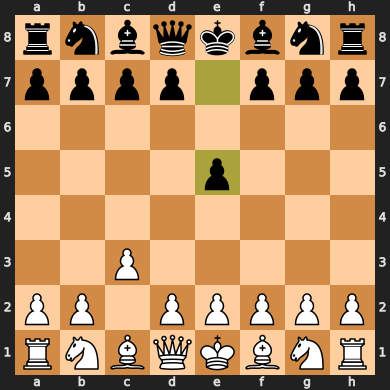

In [625]:
board = chess.Board()

moveStr = "c2c3"
move = chess.Move.from_uci(moveStr)
board.push(move)

aiMove = saved_model.predict(board)
board.push(aiMove)
board

## Trained Agent vs StockFish

In [626]:
from stockfish import Stockfish

ELO_RATING = 800
stockfish = Stockfish(path=r"F:\Machine Learning & Data Science\Reinforcement Learning\HuggingFace - DRL Course\Unit Bonus - Chess\Chess-Personal\Chess-Engine-FreeCodeCamp\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")
stockfish.reset_engine_parameters()
stockfish.set_elo_rating(ELO_RATING)
stockfish.set_skill_level(0)

 54%|█████▍    | 81/150 [00:04<00:03, 19.50it/s]

game over. You lost


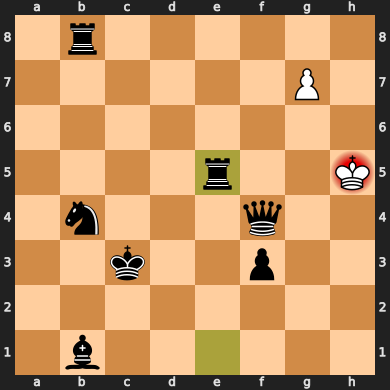

In [628]:
board = chess.Board()
allMoves = [] # list of strings for saving moves for setting pos for stockfish

MAX_NUMBER_OF_MOVES = 150
for i in tqdm(range(MAX_NUMBER_OF_MOVES)): # set a limit for the game
	
	# first my ai move
	try:
		move = saved_model.predict(board)
		board.push(move)
		allMoves.append(str(move)) # add so stockfish can see
	except:
		print("game over. You lost")
		break
	
	# # print board every 10 moves of each player
	# if i % 10 == 0: 
	# 	print(display(board._repr_svg_()))

	# then get stockfish move
	stockfish.set_position(allMoves)
	stockfishMove = stockfish.get_best_move_time(1)
	allMoves.append(stockfishMove)
	stockfishMove = chess.Move.from_uci(stockfishMove)
	board.push(stockfishMove)

	# # print board every 10 moves of each player
	# if i % 10 == 0: 
	# 	print(display(board._repr_svg_()))

board